In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pylab as plt
import matplotlib.pyplot as pyplt
from matplotlib import gridspec

import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2

import cmath
import random

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm
import scipy as sp
import scipy.fftpack

import lib
import library

# Генерация данных

In [2]:
dataset = library.creat_dataset()
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 13)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0,0.0,102.0,188.0,46.0,1.0,1.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0,0.0,102.0,188.0,46.0,1.0,1.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0,0.0,102.0,188.0,46.0,1.0,1.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0,0.0,102.0,188.0,46.0,1.0,1.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0,0.0,102.0,188.0,46.0,1.0,1.0


/home/apxapa/Документы/GitHub/2020_Project8/code/library.py:144: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('../data/data.png')
/home/apxapa/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


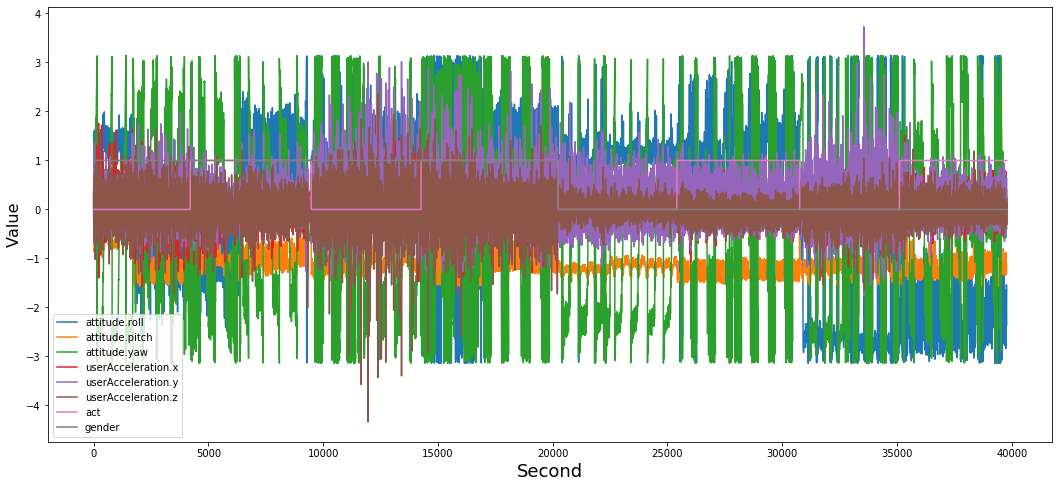

In [3]:
data = dataset.loc[(dataset['id'] < 3)|(dataset['id'] == 4)].loc[(dataset['trial'] > 0)&(dataset['trial'] < 5)]

data = data[['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z','act', 'gender']]
data.index = np.arange(len(data))

T = 50
K = 2
discrete = T//5
size_data = 39150

X_data = data.values[:size_data, :6]
List_of_x = np.arange(2*T, X_data.shape[0] - T) #ось времени

library.drow_data_multi(data)

# Извлечение признаков

Сингулярные числа (по 4 на ряд) разложения фазовой траектории:

In [4]:
N_comp = T

def get_spectrum_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'specrum_' + str(i)]
    return feature_names

feature_names = get_spectrum_names(N_comp)

# phase track для каждой точки от T до len(phase_track) - (N, len, T)
phase_track = lib.return_phase_track(X_data, T) 

# basis vector - 2 компоненты сингулярного разложения в точках 2T,2T+discrete.. max-T-discrete - (len, 2*N)
List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c = lib.local_basis_multi(phase_track, T = T, 
                                                                      N_components = N_comp, discrete = discrete)

specrum_feats = pd.DataFrame(List_of_basis_vector_s,columns = feature_names)

specrum_feats

,roll_specrum_0,roll_specrum_1,roll_specrum_2,roll_specrum_3,roll_specrum_4,roll_specrum_5,roll_specrum_6,roll_specrum_7,roll_specrum_8,roll_specrum_9,...,z_acc_specrum_40,z_acc_specrum_41,z_acc_specrum_42,z_acc_specrum_43,z_acc_specrum_44,z_acc_specrum_45,z_acc_specrum_46,z_acc_specrum_47,z_acc_specrum_48,z_acc_specrum_49
0,7.536991,7.183248,3.028250,2.980463,1.245050,1.083378,0.959384,0.531102,0.497449,0.427274,...,0.354879,0.343481,0.334933,0.265857,0.253677,0.213862,0.179788,0.135427,0.104754,7.251529e-16
1,11.400271,11.089366,5.095827,3.910886,3.847797,2.281377,1.450809,1.363604,1.081720,0.687761,...,1.025264,0.991793,0.894382,0.889070,0.856965,0.847668,0.765555,0.757068,0.622562,6.191182e-01
2,11.584641,10.320471,6.429126,3.879523,3.858760,1.907859,1.465496,1.340111,0.938938,0.688081,...,1.016023,0.989763,0.962559,0.938408,0.880826,0.876907,0.792798,0.779283,0.643671,6.209998e-01
3,11.126887,10.195186,6.768973,4.285491,3.890349,2.060183,1.409191,1.226774,0.822758,0.655821,...,1.160400,1.090574,0.959337,0.945914,0.864876,0.857104,0.813637,0.803377,0.706158,6.723262e-01
4,10.605056,10.226431,6.286216,4.894995,4.248490,2.172869,1.258247,1.075230,0.717904,0.597276,...,1.105364,1.018384,0.989848,0.931668,0.924420,0.884593,0.808001,0.761000,0.644397,6.361988e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,21.215894,19.363435,3.411772,3.161109,1.752104,1.611185,0.898093,0.753571,0.748237,0.650525,...,0.625510,0.574264,0.553734,0.477778,0.470691,0.447243,0.410728,0.352637,0.328824,2.557839e-01
3896,22.199313,18.381109,3.363006,3.032202,1.873260,1.624140,0.909016,0.741238,0.725013,0.585252,...,0.576476,0.562491,0.487336,0.481819,0.473460,0.402109,0.386398,0.353944,0.308044,1.946273e-01
3897,23.464441,17.458905,3.204594,2.874497,1.963796,1.884246,0.956806,0.710328,0.641037,0.634221,...,0.467959,0.438832,0.415838,0.405117,0.392765,0.368973,0.350249,0.219344,0.194781,1.480051e-01
3898,21.469315,19.949396,3.110702,2.602064,1.987169,1.908184,1.018382,0.780384,0.724633,0.594823,...,0.414637,0.395534,0.375198,0.368597,0.319330,0.274904,0.219030,0.202679,0.164894,1.366887e-01


Параметры авторегрессии (по 10 на ряд):




In [5]:
n = T   # with free coef

def get_autoregressive_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'autoreg_' + str(i)]
    return feature_names

feature_names = get_autoregressive_names(n)

def get_autoreg_feat_segm(ts, n):
    m = ts.shape[1]
    features = []
    for row in ts:
        X = np.zeros([m-n, n])
        Y = np.zeros(m-n)
        for i in range(m-n):
            X[i, :] = row[i:i+n]
            Y[i] = row[i+n]
        lr = LinearRegression()
        lr.fit(X, Y)
        features.append(lr.intercept_)
        features.extend(lr.coef_)  
    return features

def get_autoreg_features(X_data, n, discrete):
    if(n == 0): return np.asarray([])
    size = (X_data.shape[0]-3*T)//discrete
    params_autoreg = [None]*size
    for i in range(size):
        segm = lib.return_h(X_data, 2*T+i*discrete, 2*T)       
        params_autoreg[i] = get_autoreg_feat_segm(segm, n)   #n*N_row features
    return(np.asarray(params_autoreg))
    
params_autoreg = get_autoreg_features(X_data, n-1, discrete)
autoreg_feats = pd.DataFrame(params_autoreg,columns = feature_names)
autoreg_feats.to_csv("../data/features/autoreg_feats.csv", index=False)
autoreg_feats

,roll_autoreg_0,roll_autoreg_1,roll_autoreg_2,roll_autoreg_3,roll_autoreg_4,roll_autoreg_5,roll_autoreg_6,roll_autoreg_7,roll_autoreg_8,roll_autoreg_9,...,z_acc_autoreg_40,z_acc_autoreg_41,z_acc_autoreg_42,z_acc_autoreg_43,z_acc_autoreg_44,z_acc_autoreg_45,z_acc_autoreg_46,z_acc_autoreg_47,z_acc_autoreg_48,z_acc_autoreg_49
0,4.671356,-1.008234,0.360384,-0.370460,0.225745,-0.592969,-0.211504,0.894394,-0.193161,-0.137965,...,-0.256796,-0.465109,0.100591,0.524361,-0.267904,-0.363465,0.185640,0.275923,-0.046385,-0.226560
1,13.111147,-1.420805,1.465124,-0.643790,-0.282814,0.404153,-0.869562,0.636340,-0.189142,-0.537912,...,0.311778,-0.226381,0.074861,0.125229,0.381200,0.073551,0.234578,0.380386,0.086890,0.240266
2,13.786999,-1.081590,-0.525963,0.933789,-0.601590,-0.738977,-0.057460,0.270413,0.110748,-0.884988,...,1.365792,0.634503,-0.588245,0.162368,1.365440,1.337593,0.469445,1.387242,2.069778,0.785451
3,7.451975,0.646771,-1.753751,1.550998,-1.160744,2.480519,-1.892075,2.689632,-2.543926,2.655946,...,-0.555534,-1.000073,-0.740574,-0.681227,-0.935958,-0.630102,-0.920947,-1.223491,-0.497824,-0.757182
4,-0.628336,1.150154,-0.644974,1.726733,-2.666063,-0.117428,2.535391,-2.369485,0.565814,1.203816,...,-2.774853,4.026793,-2.006572,-0.065720,-0.988011,0.704124,-0.332192,-0.407099,-0.614365,0.085586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,-12.105166,-1.768423,0.393297,-0.282587,0.937792,0.052294,0.005611,0.068334,-0.940105,0.826184,...,0.050267,-1.203402,-0.784679,0.592439,0.871574,0.987396,0.677626,1.812515,0.381762,-0.019532
3896,-9.190326,-0.544580,-0.162886,0.229597,0.024723,0.329814,-0.150844,-1.032996,-0.157693,0.948810,...,-0.692071,0.033733,-0.650213,0.458620,-0.457950,0.566865,-0.671387,0.314061,-0.917429,-0.092339
3897,-5.176805,0.259274,-0.985112,0.113325,0.930048,0.047805,-1.006164,-0.468894,0.548053,0.665386,...,-0.273825,0.472233,-0.263364,2.337269,-2.151936,-2.030992,7.301128,-2.282331,-0.609264,1.262656
3898,-10.485059,-1.090824,-1.214723,3.784064,-1.312927,-2.702910,5.264895,-8.285068,5.301426,-0.717909,...,0.077772,-0.923780,-0.168397,-0.385836,-0.063220,0.233466,-0.503313,0.675981,-0.928570,0.928216


Коэффициенты Фурье разложения:

In [6]:
def get_fft_names(n):
    feature_names = []
    for ax in ['roll', 'pitch', 'yaw', 'x_acc', 'y_acc', 'z_acc']:
        for i in range(n):
            feature_names += [ax + '_' + 'fft_' + str(i)]
    return feature_names

feature_names = get_fft_names(2*T)

def get_fft_features_segm(ts, n):
    m = ts.shape[1]
    features = []
    
    for row in ts:
        h = sp.fftpack.rfft(row, n, axis=-1, overwrite_x=False)
        features.extend(h)
    
    return list(np.array(features)**2)

def get_fft_features(X_data, n, discrete):
    if(n == 0): return np.asarray([])
    size = (X_data.shape[0]-3*T)//discrete
    params_fft = [None]*size
    for i in range(size):
        segm = lib.return_h(X_data, 2*T+i*discrete, n)  
        params_fft[i] = get_fft_features_segm(segm, n)   #n*N_row features
    return(np.asarray(params_fft))
  
params_fft = get_fft_features(X_data, n = 2*T, discrete = discrete)
fft_feats = pd.DataFrame(params_fft,columns = feature_names)
fft_feats.to_csv("../data/features/fft_feats.csv", index=False)
fft_feats

,roll_fft_0,roll_fft_1,roll_fft_2,roll_fft_3,roll_fft_4,roll_fft_5,roll_fft_6,roll_fft_7,roll_fft_8,roll_fft_9,...,z_acc_fft_90,z_acc_fft_91,z_acc_fft_92,z_acc_fft_93,z_acc_fft_94,z_acc_fft_95,z_acc_fft_96,z_acc_fft_97,z_acc_fft_98,z_acc_fft_99
0,18866.268560,2.122149,3.310885,81.678866,106.273230,4.585390,10.798800,7.472270,1.361805,21.004341,...,0.008873,0.000073,2.461225,0.511450,0.770477,0.796658,0.375123,0.012852,1.622611,2.597686
1,18442.413797,0.512177,0.765175,71.927741,126.790125,1.238647,5.159756,7.235941,2.341931,13.497772,...,0.054697,0.846246,1.174710,1.112419,0.202969,0.624193,0.386527,0.264176,1.301424,3.190167
2,17782.518272,1.243224,1.638643,221.205709,40.116021,9.850671,3.015823,2.433564,23.004067,7.222349,...,0.092859,1.606543,0.145890,0.022180,1.018894,0.083184,1.202576,1.530649,0.271205,2.556875
3,17104.109388,6.890511,5.163327,0.615304,295.654784,0.637748,15.415112,0.035398,9.539325,3.143661,...,0.044460,2.522265,0.079543,0.354758,0.000142,2.646838,0.009556,0.555588,0.044256,4.778377
4,15957.184776,24.139712,24.024125,166.692915,77.261798,2.500752,2.048749,6.294702,34.154673,1.366637,...,0.013453,1.980691,0.656558,0.049196,0.832219,0.010036,1.689772,1.163919,0.584977,2.410989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,47870.192188,10.744497,31.503473,60.695109,741.748714,7.327387,39.528677,8.649952,8.531553,0.304207,...,0.005158,0.105741,0.878643,0.098516,0.013281,0.019784,0.182960,0.455795,0.000234,0.001314
3896,45886.903473,101.388701,0.568817,647.648853,18.211945,32.069821,20.357115,0.012663,0.217856,1.616986,...,0.241546,0.390085,0.005276,0.091280,0.002592,0.003199,0.065668,0.010527,0.079119,0.168615
3897,46563.064375,49.341668,25.951260,181.132213,544.099807,16.056395,55.724081,1.326933,0.238449,0.019626,...,0.254093,0.034814,0.079687,0.214779,0.101863,0.294385,0.005386,0.028637,0.066727,0.028921
3898,49943.606735,20.586798,35.592641,146.437509,583.507126,18.071404,46.035955,0.797093,34.119014,0.282655,...,0.272417,0.020069,0.310227,0.019791,0.040221,0.000020,0.025606,0.175444,0.010809,0.408361


In [7]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import GroupKFold

def selecting(X_feat,y, model):
    mask1 = [True if i % 600 < 400 else False for i in range(3900)]
    mask2 = [True if i % 600 > 399 else False for i in range(3900)]
    X_train, y_train = X_feat[mask1], y[mask1]
    X_test, y_test = X_feat[mask2], y[mask2]

    X_train = sklearn.preprocessing.MinMaxScaler().fit_transform(X_train)
    X_test = sklearn.preprocessing.MinMaxScaler().fit_transform(X_test)

    select_feat = SelectPercentile(chi2, percentile=5)
    X_train = select_feat.fit_transform(X_train, y_train)

    best_feat = select_feat.get_support()
    bestmask = select_feat.get_support(indices=False)
    best = [[x,z] for x,y,z in zip(X_feat.columns, select_feat.get_support(), select_feat.scores_) if y == 1]
    best = pd.DataFrame(best) 
    
    X_test = select_feat.transform(X_test)
    plt.rcParams['figure.figsize'] = (18.0, 8.0)
    plt.bar([ str(i) for i in best[0]], best[1], color='g')
    
    groups = np.arange(len(y_train)) // 400
    cv_gen = GroupKFold(4).split(X_train, y_train, groups)
    cv = list(cv_gen)

    sfs = SFS(model, k_features=20, forward=False, floating=True, scoring='accuracy', 
          cv=cv, n_jobs=-1, verbose = 2)

    sfs.fit(X_train, y_train)
    print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))

    X_train_sfs = sfs.transform(X_train)
    X_test_sfs = sfs.transform(X_test)
    
    best2 = np.asarray(best[0])
    mask = [i in sfs.k_feature_idx_ for i,x in enumerate(best[0])]
    best2 = best2[mask]
    
    df_train = pd.DataFrame(data=X_train_sfs, columns=best2)
    df_train.insert(2, "y", y_train, True)
    df_test = pd.DataFrame(data=X_test_sfs, columns=best2)
    df_test.insert(2, "y", y_test, True)
    
    return df_train, df_test

result = np.zeros((2, 7))

# Деятельность

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.5s finished

[2020-03-31 14:49:57] Features: 59/20 -- score: 0.8203125[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished

[2020-03-31 14:50:04] Features: 58/20 -- score: 0.8396428571428572[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Do

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.5s finished

[2020-03-31 14:52:10] Features: 42/20 -- score: 0.8983482142857143[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.6s finished

[2020-03-31 14:52:18] Features: 41/20 -- score: 0.8992857142857144[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]

[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    2.9s finished

[2020-03-31 14:54:29] Features: 28/20 -- score: 0.9123214285714286[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    3.1s finished

[2020-03-31 14:54:35] Features: 27/20 -- score: 0.9123214285714286[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    3.2s finished

[2020-03-31 14:54:41] Features: 26/20 -- score: 0.911696428

best combination (ACC: 0.913): (0, 1, 5, 6, 7, 8, 11, 12, 13, 14, 17, 24, 26, 32, 34, 49, 51, 53, 56, 58)



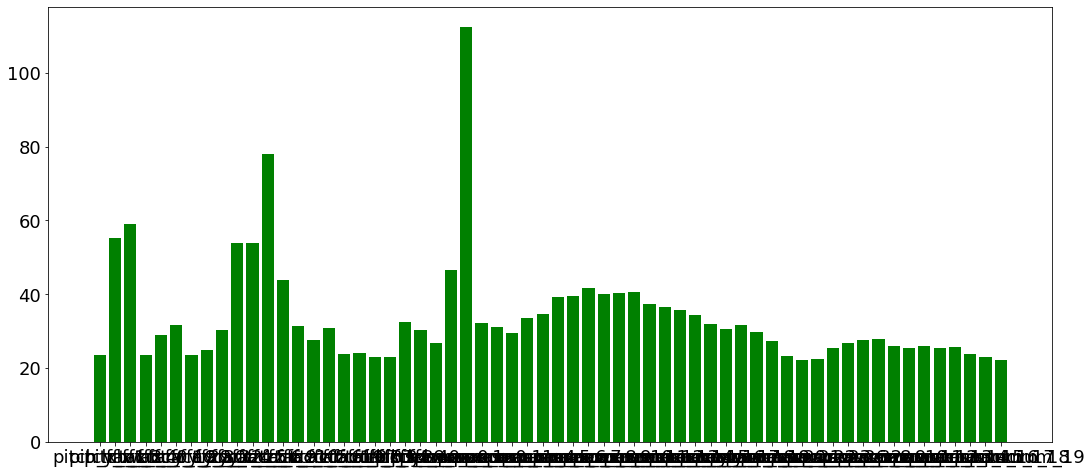

In [8]:
# features:
X_feat = pd.concat([fft_feats, autoreg_feats, specrum_feats], axis=1)
y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 6]) if i % discrete == 0])

df_train_act, df_test_act = selecting(X_feat,y, LogisticRegression())
df_train_act.to_csv("../data/df_train_act.csv", index=False)
df_test_act.to_csv("../data/df_test_act.csv", index=False)

X_train_act, y_train_act = df_train_act.drop(['y'], axis=1), df_train_act[['y']]
X_test_act, y_test_act = df_test_act.drop(['y'], axis=1), df_test_act[['y']]
best_act = X_train_act.columns

# Тестовая выборка

In [9]:
#clf = LogisticRegression(random_state=0)
#scores = cross_val_score(clf, X_train_sfs, y_train, cv=cv)
#print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

clf = LogisticRegression(random_state=0).fit(X_train_act, y_train_act)
sc = clf.score(X_test_act, y_test_act)
result[0,0] = sc
print('на тестовой выборке: %0.3f' % sc)

на тестовой выборке: 0.908


/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Распознавание пола

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.9s finished

[2020-03-31 14:56:00] Features: 59/20 -- score: 0.8967857142857143[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished

[2020-03-31 14:56:05] Features: 58/20 -- score: 0.8989732142857143[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.0s finished

[2020-03-31 14:57:30] Features: 44/20 -- score: 0.9211607142857143[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    1.3s finished

[2020-03-31 14:57:35] Features: 43/20 -- score: 0.9211607142857143[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.2s finished

[2020-03-31 14:57:39] Features: 42/20 -- score: 0.9212053571428571[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    2.0s finished

[2020-03-31 14:59:02] Features: 27/20 -- score: 0.9231696428571429[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    2.2s finished

[2020-03-31 14:59:09] Features: 27/20 -- score: 0.9237946428571429[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 conc

best combination (ACC: 0.927): (0, 1, 13, 16, 18, 19, 23, 24, 25, 30, 31, 32, 34, 36, 37, 38, 39, 40, 42, 46)



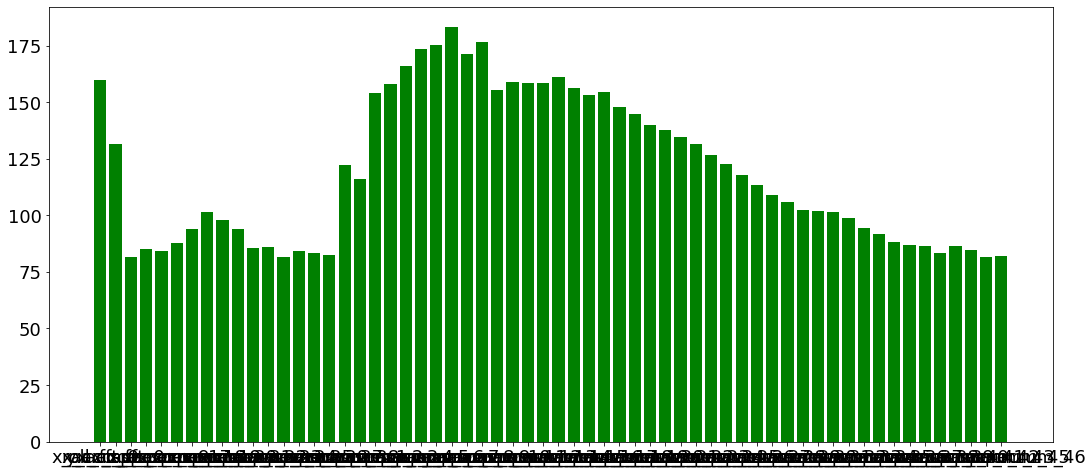

In [10]:
# features:
X_feat = pd.concat([fft_feats, autoreg_feats, specrum_feats], axis=1)
y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 7]) if i % discrete == 0])

df_train_gen, df_test_gen = selecting(X_feat,y, LogisticRegression())
df_train_gen.to_csv("../data/df_train_gen.csv", index=False)
df_test_gen.to_csv("../data/df_test_gen.csv", index=False)

X_train_gen, y_train_gen = df_train_gen.drop(['y'], axis=1), df_train_gen[['y']]
X_test_gen, y_test_gen = df_test_gen.drop(['y'], axis=1), df_test_gen[['y']]
best_gen = X_train_gen.columns

# Тестовая выборка

In [11]:
#clf = LogisticRegression(random_state=0)
#scores = cross_val_score(clf, X_train_sfs, y_train, cv=cv)
#print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2)) 
    
clf = LogisticRegression(random_state=0).fit(X_train_gen, y_train_gen)
sc = clf.score(X_test_gen, y_test_gen)
result[0,1] = sc
print('на тестовой выборке: %0.3f' % sc)

на тестовой выборке: 0.959


/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Анализ результатов

In [12]:
result[0,2] = len(set(best_act)&set(best_gen))

# Активность на признаках оптимальных для гендера
clf = LogisticRegression(random_state=0).fit(X_train_gen, y_train_act)
sc = clf.score(X_test_gen, y_test_act)
print('на тестовой выборке: %0.3f' % sc)
result[0,3] = sc

# Гендер на признаках оптимальных для активности
clf = LogisticRegression(random_state=0).fit(X_train_act, y_train_gen)
sc = clf.score(X_test_act, y_test_gen)
print('на тестовой выборке: %0.3f' % sc)
result[0,4] = sc

/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


на тестовой выборке: 0.700
на тестовой выборке: 0.897


In [13]:
# Активность на признаках + гендер
clf = LogisticRegression(random_state=0).fit(X_train_gen, y_train_gen)
y_pred_gen = clf.predict(X_train_gen)
X_train_act_g = X_train_act.assign(e=y_pred_gen)
y_pred_gen = clf.predict(X_test_gen)
X_test_act_g = X_test_act.assign(e=y_pred_gen)

clf = LogisticRegression(random_state=0).fit(X_train_act_g, y_train_act)
sc = clf.score(X_test_act_g, y_test_act)
print('на тестовой выборке: %0.3f' % sc)
result[0,5] = sc

# Гендер на признаках + активность
clf = LogisticRegression(random_state=0).fit(X_train_act, y_train_act)
y_pred_act = clf.predict(X_train_act)
X_train_gen_a = X_train_gen.assign(e=y_pred_act)
y_pred_act = clf.predict(X_test_act)
X_test_gen_a = X_test_gen.assign(e=y_pred_act)

clf = LogisticRegression(random_state=0).fit(X_train_gen_a, y_train_gen)
sc = clf.score(X_test_gen_a, y_test_gen)
print('на тестовой выборке: %0.3f' % sc)
result[0,6] = sc

/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


на тестовой выборке: 0.918
на тестовой выборке: 0.946


/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# То же самое для SVM

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   20.6s finished

[2020-03-31 15:00:27] Features: 59/20 -- score: 0.8067410714285714[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   22.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished

[2020-03-31 15:00:51] Features: 58/20 -- score: 0.8458928571428571[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.3s finished

[2020-03-31 15:08:04] Features: 44/20 -- score: 0.8954464285714285[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   10.2s finished

[2020-03-31 15:08:32] Features: 43/20 -- score: 0.8963839285714286[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    6.7s finished

[2020-03-31 15:08:58] Features: 42/20 -- score: 0.8966964285714286[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   11.9s finished

[2020-03-31 15:16:42] Features: 27/20 -- score: 0.9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    8.3s finished

[2020-03-31 15:17:05] Features: 27/20 -- score: 0.9008482142857143[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.

best combination (ACC: 0.906): (1, 2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 24, 26, 32, 50, 52, 54, 55)



/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


на тестовой выборке: 0.893


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   11.6s finished

[2020-03-31 15:22:44] Features: 59/20 -- score: 0.9146428571428572[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished

[2020-03-31 15:22:59] Features: 58/20 -- score: 0.9167857142857143[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.5s finished

[2020-03-31 15:26:01] Features: 44/20 -- score: 0.9295982142857142[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    2.4s finished

[2020-03-31 15:26:11] Features: 43/20 -- score: 0.9301785714285715[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parall

[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    3.9s finished

[2020-03-31 15:29:14] Features: 28/20 -- score: 0.931875[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    5.4s finished

[2020-03-31 15:29:29] Features: 28/20 -- score: 0.9328125[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    5.4s finished

[2020-03-31 15:29:40] Features: 27/20 -- score: 0.933125[Parallel(n_jobs=-1)]:

best combination (ACC: 0.933): (0, 1, 2, 8, 15, 20, 25, 28, 30, 31, 32, 33, 34, 35, 41, 42, 43, 53, 54, 59)



/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


на тестовой выборке: 0.984


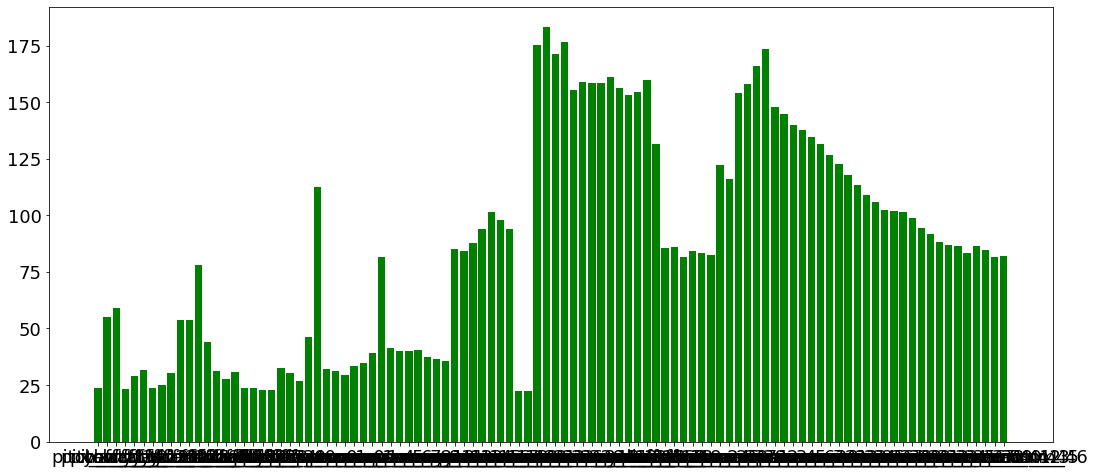

In [14]:
# features act:
X_feat = pd.concat([fft_feats, autoreg_feats, specrum_feats], axis=1)
y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 6]) if i % discrete == 0])

df_train_act, df_test_act = selecting(X_feat,y, svm.SVC(random_state=0))
df_train_act.to_csv("../data/df_train_act2.csv", index=False)
df_test_act.to_csv("../data/df_test_act2.csv", index=False)

X_train_act, y_train_act = df_train_act.drop(['y'], axis=1), df_train_act[['y']]
X_test_act, y_test_act = df_test_act.drop(['y'], axis=1), df_test_act[['y']]
best_act2 = X_train_act.columns

#clf = svm.SVC()
#scores = cross_val_score(clf, X_train_sfs, y_train, cv=cv)
#print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

clf = svm.SVC(random_state=0).fit(X_train_act, y_train_act)
sc = clf.score(X_test_act, y_test_act)
result[1,0] = sc
print('на тестовой выборке: %0.3f' % sc)

# features gen:
X_feat = pd.concat([fft_feats, autoreg_feats, specrum_feats], axis=1)
y = np.asarray([1 if x==1 else 0  for i,x in enumerate(data.values[2*T:size_data-T, 7]) if i % discrete == 0])

df_train_gen, df_test_gen = selecting(X_feat,y, svm.SVC(random_state=0))
df_train_gen.to_csv("../data/df_train_gen2.csv", index=False)
df_test_gen.to_csv("../data/df_test_gen2.csv", index=False)

X_train_gen, y_train_gen = df_train_gen.drop(['y'], axis=1), df_train_gen[['y']]
X_test_gen, y_test_gen = df_test_gen.drop(['y'], axis=1), df_test_gen[['y']]
best_gen2 = X_train_gen.columns

#clf = LogisticRegression(random_state=0)
#scores = cross_val_score(clf, X_train_sfs, y_train, cv=cv)
#print("Accuracy cross validation: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2)) 
    
clf = svm.SVC(random_state=0).fit(X_train_gen, y_train_gen)
sc = clf.score(X_test_gen, y_test_gen)
result[1,1] = sc
print('на тестовой выборке: %0.3f' % sc)

result[1,2] = len(set(best_act2)&set(best_gen2))

In [15]:
# Активность на признаках оптимальных для гендера
clf = svm.SVC(random_state=0).fit(X_train_gen, y_train_act)
sc = clf.score(X_test_gen, y_test_act)
print('на тестовой выборке: %0.3f' % sc)
result[1,3] = sc

# Гендер на признаках оптимальных для активности
clf = svm.SVC(random_state=0).fit(X_train_act, y_train_gen)
sc = clf.score(X_test_act, y_test_gen)
print('на тестовой выборке: %0.3f' % sc)
result[1,4] = sc

# Активность на признаках + гендер
clf = svm.SVC(random_state=0).fit(X_train_gen, y_train_gen)
y_pred_gen = clf.predict(X_train_gen)
X_train_act_g = X_train_act.assign(e=y_pred_gen)
y_pred_gen = clf.predict(X_test_gen)
X_test_act_g = X_test_act.assign(e=y_pred_gen)

clf = svm.SVC(random_state=0).fit(X_train_act_g, y_train_act)
sc = clf.score(X_test_act_g, y_test_act)
print('на тестовой выборке: %0.3f' % sc)
result[1,5] = sc

# Гендер на признаках + активность
clf = svm.SVC(random_state=0).fit(X_train_act, y_train_act)
y_pred_act = clf.predict(X_train_act)
X_train_gen_a = X_train_gen.assign(e=y_pred_act)
y_pred_act = clf.predict(X_test_act)
X_test_gen_a = X_test_gen.assign(e=y_pred_act)

clf = svm.SVC(random_state=0).fit(X_train_gen_a, y_train_gen)
sc = clf.score(X_test_gen_a, y_test_gen)
print('на тестовой выборке: %0.3f' % sc)
result[1,6] = sc

/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


на тестовой выборке: 0.866


/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


на тестовой выборке: 0.889


/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


на тестовой выборке: 0.914


/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


на тестовой выборке: 0.957


/home/apxapa/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
columns = ["act", "gender", "common feat", "act on gen feats", "gen on act feats", "act on +gen","gen on +act"]
rows = ["LogRegression", "SVM"]
res = pd.DataFrame(data=result, index=rows, columns=columns)
res = np.round(res, 3)
res.to_csv("../data/result.csv", index=False)
res

,act,gender,common feat,act on gen feats,gen on act feats,act on +gen,gen on +act
LogRegression,0.908,0.959,4.0,0.700,0.897,0.918,0.946
SVM,0.893,0.984,1.0,0.866,0.889,0.914,0.957
